<a href="https://colab.research.google.com/github/Pavionio/Fear_and_Hate_in_Taxi/blob/main/anomaly_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install geopandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import random
import geopy.distance as gp
import plotly.express as px
import math
import geopandas as gpd
from shapely.geometry import Point
import shapely
import json
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from prophet import Prophet
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
trip_duration = pd.read_csv('/content/gdrive/MyDrive/intensive/Project/nyc_taxi_trip_duration.csv')
weather = pd.read_csv('/content/gdrive/MyDrive/intensive/Project/nyc_2016_weather.csv')

In [ ]:
!unzip -q /content/gdrive/My\ Drive/intensive/Project/trips_2015-2016.zip

In [ ]:
trip_duration = pd.read_csv('/content/yellow_tripdata_2015-01.csv')

In [17]:
trip_duration

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,distance,pickup_datetime,ds,parameter_anomaly
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,...,1.0,0.5,3.25,0.0,0.3,17.05,1.59,2015-01-15 19:05:39,2015-01-15,0
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,...,0.5,0.5,2.00,0.0,0.3,17.80,3.30,2015-01-10 20:33:38,2015-01-10,0
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,...,0.5,0.5,0.00,0.0,0.3,10.80,1.80,2015-01-10 20:33:38,2015-01-10,0
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,...,0.5,0.5,0.00,0.0,0.3,4.80,0.50,2015-01-10 20:33:39,2015-01-10,0
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,...,0.5,0.5,0.00,0.0,0.3,16.30,3.00,2015-01-10 20:33:39,2015-01-10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12748981,1,2015-01-10 19:01:44,2015-01-10 19:05:40,2,1.00,-73.951988,40.786217,1,N,-73.953735,...,0.0,0.5,1.25,0.0,0.3,7.55,1.00,2015-01-10 19:01:44,2015-01-10,0
12748982,1,2015-01-10 19:01:44,2015-01-10 19:07:26,2,0.80,-73.982742,40.728184,1,N,-73.974976,...,0.0,0.5,2.00,0.0,0.3,8.80,0.80,2015-01-10 19:01:44,2015-01-10,0
12748983,1,2015-01-10 19:01:44,2015-01-10 19:15:01,1,3.40,-73.979324,40.749550,1,N,-73.969101,...,0.0,0.5,0.00,0.0,0.3,14.30,3.40,2015-01-10 19:01:44,2015-01-10,0
12748984,1,2015-01-10 19:01:44,2015-01-10 19:17:03,1,1.30,-73.999565,40.738483,1,N,-73.981819,...,0.0,0.5,2.25,0.0,0.3,13.55,1.30,2015-01-10 19:01:44,2015-01-10,0


In [ ]:
trip_duration['distance'] = trip_duration.trip_distance
trip_duration['pickup_datetime'] = trip_duration.tpep_pickup_datetime	

In [ ]:
def geo_anomalies(data : pd.DataFrame) -> None :
    
    
    df_for_pickup = pd.read_csv('/content/gdrive/MyDrive/intensive/Project/taxi_zones.csv')  
    df_for_dropoff = pd.read_csv('/content/gdrive/MyDrive/intensive/Project/taxi_zones.csv')  #update with the great help of Pavel Fadeev

    polygon_for_pickup = gpd.GeoDataFrame(geometry=shapely.wkt.loads(df_for_pickup.the_geom))
    #polygon_for_dropoff = gpd.GeoDataFrame(geometry=shapely.wkt.loads(df_for_dropoff.the_geom))

    ls=[]

    for _,row in trip_duration.iterrows():
        ls.append(polygon_for_pickup.contains(Point(row['pickup_longitude'],row['pickup_latitude'])).any() and polygon_for_pickup.contains(Point(row['dropoff_longitude'],row['dropoff_latitude'])).any())

    
    pickup_longitude = trip_duration[['id', 'pickup_longitude']].rename(columns={'pickup_longitude': 'longitude'})
    pickup_longitude['type'] = 'pickup'
    dropoff_longitude = trip_duration[['id', 'dropoff_longitude']].rename(columns={'dropoff_longitude': 'longitude'})
    dropoff_longitude['type'] = 'dropoff'

    longitudes = pd.concat((pickup_longitude, dropoff_longitude))

    pickup_latitude = trip_duration[['id', 'pickup_latitude']].rename(columns={'pickup_latitude': 'latitude'})
    pickup_latitude['type'] = 'pickup'
    dropoff_latitude = trip_duration[['id', 'dropoff_latitude']].rename(columns={'dropoff_latitude': 'latitude'})
    dropoff_latitude['type'] = 'dropoff'

    latitudes = pd.concat((pickup_latitude, dropoff_latitude))

    coords = pd.merge(longitudes, latitudes, on=['id', 'type'])
        

    with open('/content/gdrive/MyDrive/intensive/Project/NYC Taxi Zones.geojson') as f:
        taxi_zones = json.load(f)

    fig = px.scatter_mapbox(coords, lat='latitude', lon='longitude', hover_name='type')
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(mapbox_bounds={"west": -180, "east": -50, "south": 20, "north": 90})
    fig.update_traces(cluster=dict(enabled=True))
    fig.update_layout(
        mapbox = {
            'style': "open-street-map",
            'center': { 'lon': -73.9662, 'lat': 40.7834},
            'zoom': 9, 'layers': [{
                'source': taxi_zones,
                'type': "fill", 'below': "traces", 'color': "gray", 'name': 'Область работы такси',
            'opacity': 0.5}]},
        margin = {'l':0, 'r':0, 'b':0, 't':0})
    fig.show()



    data['geo_anomalies'] = ls



In [ ]:
def show_geo_map(data : pd.DataFrame) -> None :

    pickup = data[['pickup_latitude', 'pickup_longitude']].rename(columns={'pickup_longitude': 'longitude', 'pickup_latitude' :'latitude'})
    dropoff = data[['pickup_latitude', 'pickup_longitude']].rename(columns={'pickup_longitude': 'longitude', 'pickup_latitude' :'latitude'})

    coords = pd.concat((pickup, dropoff))
    geo_coords = gpd.GeoDataFrame(coords, geometry=gpd.points_from_xy(coords.longitude, coords.latitude))


    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world[world.continent == 'North America'].plot(color='white', edgecolor='black')
    geo_coords.plot(ax=ax, color='purple') # Расположение точек начала и конца поездок
    plt.show()


In [19]:
def iso_forest_trip_count_anomalies(data : pd.DataFrame) -> None :

  
    data = data.sort_values(by=['pickup_datetime']).copy()
    cols = data.columns
    data['ds'] = pd.to_datetime(data['pickup_datetime'].str.slice(stop=10))
    duration = data.groupby('ds',as_index=False).count()
    duration.rename(columns={cols[-2]: "y"},inplace=True)
    duration = duration[['ds','y']]
    model = IsolationForest(n_estimators=150, max_samples='auto', contamination=float(0.05), max_features=1.0)

    model.fit(duration[['y']])
    
    score_anomalies =  model.decision_function(duration[['y']])
    #print('Isolation_Forest score is ', np.mean([-1*s + 0.5 for s in score_anomalies])
    
    duration['day_anomaly'] = model.predict(duration[['y']])

    an = duration.loc[duration['day_anomaly'] == -1]
    an.sort_values(by=['y'])

    fig = plt.figure(figsize=(15,10)) 
    plt.plot(duration.ds, duration['y'], c='#264FA3', linewidth=3.0)
    plt.scatter(an.ds, an['y'], c='red', s=9, linewidth=5.0)
    plt.show()

    return duration


In [ ]:
def trip_nlo_anomalies(data : pd.DataFrame) -> None :


    LOF = LocalOutlierFactor(n_neighbors=50, contamination='auto')
    x = data[['trip_duration','distance']].values
    y_pred = LOF.fit_predict(x)

    plt.figure(figsize=(12,12))


    in_mask = [True if i == 1 else False for i in y_pred]
    out_mask = [True if i == -1 else False for i in y_pred]

    plt.title("Local Outlier Factor (LOF)")

    a = plt.scatter(x[in_mask, 0], x[in_mask, 1], c = 'blue', edgecolor = 'k', s = 30)

    b = plt.scatter(x[out_mask, 0], x[out_mask, 1], c = 'red', edgecolor = 'k', s = 30)
    plt.axis('tight')
    plt.xlabel('trip_duration');
    plt.ylabel('distance');
    plt.show()

    data['nlo_anomaly'] = y_pred


def trip_parameter_anomalies(data : pd.DataFrame) -> None :

    passenger_count_m = False
    passenger_count_l = False
    distance_anomaly = False
    duration_anomaly = False

    if 'distance'  in data.columns:
        distance_anomaly = data.distance == 0

    if 'trip_duration' in data.columns:
        duration_anomaly = data.trip_duration == 0
    
    if 'trip_duration' in data.columns:
        passenger_count_m = data.passenger_count > 7
        passenger_count_l = data.passenger_count == 0

    data['parameter_anomaly'] =  0 
    data.loc[(passenger_count_m) | (passenger_count_l) | (distance_anomaly) | (duration_anomaly), 'parameter_anomaly'] = -1


def get_distance(p1, p2):
    # p1 и p2 - это кортежи из двух элементов - координаты точек
    radius = 6373.0

    lon1 = math.radians(p1[0])
    lat1 = math.radians(p1[1])
    lon2 = math.radians(p2[0])
    lat2 = math.radians(p2[1])

    d_lon = lon2 - lon1
    d_lat = lat2 - lat1

    a = math.sin(d_lat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(d_lon / 2) ** 2
    c = 2 * math.atan2(a ** 0.5, (1 - a) ** 0.5)

    distance = radius * c
    return distance

In [20]:
def prophet_trip_count_anomalies(data : pd.DataFrame, num_of_periods : int ) -> None :

        data = data.sort_values(by=['pickup_datetime']).copy()
        cols = data.columns
        data['ds'] = pd.to_datetime(data['pickup_datetime'].str.slice(stop=10))

        duration = data.groupby('ds',as_index=False).count()
        duration.rename(columns={cols[-2]: "y"},inplace=True)
        duration = duration[['ds','y']]

        m = Prophet()
        m.fit(duration)

        future = m.make_future_dataframe(periods=30)
        forecast = m.predict(future)
        m.plot(forecast)
        plt.show()

        m.plot_components(forecast)
        plt.show()


        performance = pd.merge(duration, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

        performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
        print(f'\n \n The MAE for the model is {performance_MAE}')

        performance_MAPE = mean_absolute_percentage_error(performance['y'], performance['yhat'])
        print(f'The MAPE for the model is {performance_MAPE} \n \n')


        performance['anomaly'] = performance.apply(lambda rows: 1 if ((rows.y<=rows.yhat_lower)|(rows.y>=rows.yhat_upper)) else 0, axis = 1)

        anomalies = performance[performance['anomaly']==1].sort_values(by='ds')

        fig = plt.figure(figsize=(15,10)) 

        sns.scatterplot(x='ds', y='y', data=performance, hue='anomaly',label='Аномалии')
        sns.lineplot(x='ds', y='yhat', data=performance, color='black',label='Количество поездок')

In [ ]:
def Catch_Anomalies(data : pd.DataFrame, search_geo_anomalies=True, show_small_geo_map=True, search_count_anomalies_by_iso=True,\
                    search_count_anomalies_by_prophet=True, num_of_periods=30, search_nlo_anomalies=True,search_parameter_anomalies=True):



    ''' 
          
    '''


    day_anomalies_iso =None
    day_anomalies_prophet = None


    if 'pickup_longitude' in data.columns and search_geo_anomalies: 
      geo_anomalies(data)

    if 'pickup_longitude' in data.columns and show_small_geo_map: 
      show_geo_map(data)

    if 'pickup_datetime' in data.columns and search_count_anomalies_by_iso:
      day_anomalies_iso = iso_forest_trip_count_anomalies(data)

    if 'pickup_datetime' in data.columns and search_count_anomalies_by_prophet:
      day_anomalies_prophet = prophet_trip_count_anomalies(data, num_of_periods)
    
    if 'distance' and 'trip_duration' in data.columns and search_nlo_anomalies:
      trip_nlo_anomalies(data)

    if search_parameter_anomalies:
      trip_parameter_anomalies(data)
    
    return day_anomalies_iso, day_anomalies_prophet

In [21]:



Catch_Anomalies(trip_duration,search_geo_anomalies=False, show_small_geo_map=False)

KeyError: ignored

In [ ]:
def mask_f(col):
  return (col.mean() - 3*col.std()), (col.mean()  + 3*col.std())

In [ ]:
mask1 = mask_f(trip_duration.trip_duration)
mask2 = mask_f(trip_duration.distance)
td = trip_duration.trip_duration[(trip_duration.trip_duration > mask1[0]) & (trip_duration.trip_duration < mask1[1])]
ds = trip_duration.distance[(trip_duration.distance > mask2[0]) & (trip_duration.distance < mask2[1])]

In [ ]:
trip_duration.sort_values(by=['distance']).tail(20)

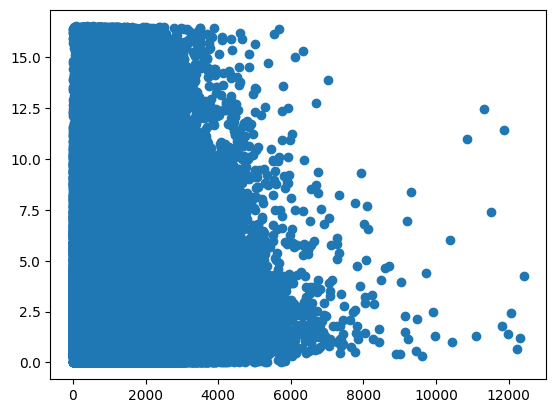

In [ ]:
plt.scatter(td[:len(ds)],ds)

In [ ]:
def mask_f(col):
  return (col.mean() - 3*col.std()), (col.mean()  + 3*col.std())


mask = mask_f(trip_duration.distance)
sns.displot(trip_duration.distance[(trip_duration.distance > mask[0]) & (trip_duration.distance < mask[1])], kind="kde")
mask = mask_f(trip_duration.trip_duration)
sns.displot(trip_duration.trip_duration[(trip_duration.distance > mask[0]) & (trip_duration.trip_duration < mask[1])], kind="kde")
mask = mask_f(trip_duration.avg_speed)
sns.displot(trip_duration.avg_speed[(trip_duration.avg_speed > mask[0]) & (trip_duration.avg_speed < mask[1])], kind="kde")